# this is used to test matched filter method

In [1]:
%matplotlib inline
import astropy.io.fits as fits
from astropy.table import Table
import scipy.ndimage as sn
import numpy as np
import csv
import CoordinateConversion as CC
import matplotlib.pyplot as plt
from matplotlib import cm
# import pandas as pd
import math as m
import PyAstronomy as PA
from PyAstronomy import pyasl as PAP
from scipy import signal
import scipy.optimize as SO
import galpy.util.bovy_coords as gub
import finder as fd

In [2]:
# progenitor 1 age 10.1174 gyr

dpath = '/Users/htian/Documents/work/data/SDSS/'
dpath_t = '/Users/htian/Documents/work/data/MF/'
dname = 'sdss.fits'
outputfn = 'Palomar5_3.fits'
fn_t = 'progenitor.1.dat'



In [3]:
# Dt = fits.open(dpath+dname)
# Dsdss= Dt[1].data
# ra = Dsdss['Alpha']
# dec = Dsdss['Delta']
# gmag = Dsdss['sdss_g']
# rmag = Dsdss['sdss_r']
# Dt.close()
# # select the stars around Palomar 5 GC and save the selected data into fits file
# ind = (np.abs(ra-229)<3) & (np.abs(dec<3))
# n = len(ra[ind])
# c1 = fits.Column(name="ra",array=ra[ind],format='F')
# c2 = fits.Column(name="dec",array=dec[ind],format='F')
# c3 = fits.Column(name='gmag',array=gmag[ind],format='F')
# c4 = fits.Column(name='rmag',array=rmag[ind],format='F')
# output = fits.BinTableHDU.from_columns([c1,c2,c3,c4])
# output.writeto(dpath+outputfn)

In [4]:
DD = fits.open(dpath+outputfn)
datap = DD[1].data
rap = datap['ra']
decp = datap['dec']
gmagp = datap['gmag']
rmagp = datap['rmag']
gmrp = gmagp-rmagp

In [5]:
# read template file
rmagt,gmagt,yt,xt,zt = np.loadtxt(dpath_t+fn_t,skiprows=39,unpack=True,delimiter=',',\
                  dtype={'names':('rmagt','gmagt','yt','xt','zt'),\
                        'formats':(float,float,float,float,float)},\
                                 usecols=(1,8,28,29,30))
gmrt = gmagt - rmagt

In [6]:
#  generate the template
bs_c = 0.1
bs_m = 0.5
min_c,max_c = -0.5,1.5
min_m,max_m = 12,22
n_c = int((max_c-min_c)/bs_c)
n_m = int((max_m-min_m)/bs_m)
m_array = np.linspace(min_m,max_m,n_m+1)
c_array = np.linspace(min_c,max_c,n_c+1)
nTmp, xedges, yedge = np.histogram2d(gmagt,gmrt, bins=(m_array, c_array))
sTmp = sn.gaussian_filter(nTmp,sigma=(0.25,0.25),order=0)
print(np.shape(nTmp))

(20, 20)


[-0.5, 1.5, 22, 12]

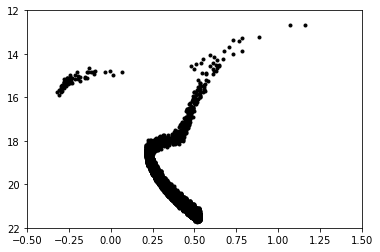

In [7]:
plt.plot(gmagt-rmagt,gmagt,'k.')
plt.axis([-0.5,1.5,22,12])

In [8]:
# # print(np.shape(nTmp0))
# plt.contourf(c_array[:n_c]+bs_c/2,m_array[:n_m]+bs_m/2,nTmp[::-1,:],\
#             levels=np.linspace(0.1,100.1,11),cmap=plt.cm.gist_rainbow,vmin=0.1,vmax=100)
# plt.colorbar()

126094
0.0
21 21
21 21
(20, 20)


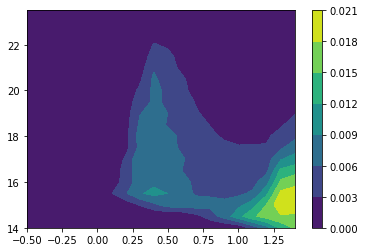

In [9]:
indtbg = np.abs(decp)<1
print(len(rap[indtbg]))
T_Bg, xedges, yedges = np.histogram2d(gmagp[indtbg],gmrp[indtbg],bins=(m_array+2, c_array))
sBg = sn.gaussian_filter(T_Bg/np.sum(T_Bg),sigma=(0.25,0.25),order=0)
sBg = sBg*1.0/np.sum(sBg)#np.sum(nBg)
print(np.min(sBg))
print(len(xedges),len(yedges))
print(len(c_array),len(m_array))
print(np.shape(T_Bg))
plt.contourf(yedges[:len(yedges)-1],xedges[:len(xedges)-1],T_Bg[::-1,:]/np.sum(T_Bg))
plt.colorbar()

In [10]:
n_background = 10
bs_sky = 0.1
min_ra,max_ra = 226,232
min_dec,max_dec = -3,3
n_ra = int((max_ra-min_ra)/bs_sky)
n_dec = int((max_dec-min_dec)/bs_sky)
ra_array = np.linspace(min_ra,max_ra,n_ra+1)
dec_array = np.linspace(min_dec,max_dec,n_dec+1)
mf = np.zeros((n_ra,n_dec))
snmf = np.zeros((n_ra,n_dec))
nnn = np.zeros((n_ra,n_dec))
cmf = np.zeros((n_ra,n_dec))
for i in range(0,n_ra):#(14,15):
    c_ra= min_ra+i*bs_sky+bs_sky*0.5
    for j in range(0,n_dec):#(14,15):
        c_dec = min_dec+j*bs_sky+bs_sky*0.5
        ind_a = np.zeros(len(rap))
        ind_c = (np.abs(rap-c_ra)<(bs_sky*0.5)) & (np.abs(decp-c_dec)<(bs_sky*0.5))
        ind_b = (np.abs(rap-c_ra)<(bs_sky*0.5*n_background)) & \
        (np.abs(decp-c_dec)<(bs_sky*0.5*n_background))
        ind_a[ind_b] = 1    # the stars in the background bins
        ind_a[ind_c] = 2    # the stars in the target bin
        nTg, xedges, yedge = np.histogram2d(gmagp[ind_a==2],gmrp[ind_a==2], \
                                            bins=(m_array+2, c_array))
        if np.sum(nTg)>0:
            ssBg = sBg*np.sum(nTg)
            mf[i,j] = fd.Matched_filter(nTg,nTmp*1.0/np.sum(nTmp),ssBg,\
                                    binsize=[bs_c,bs_m])
            del ssBg
#         nnn[i,j] = len(rap[ind_c])
#         res = nTg-sBg
#         res[res<0]=0
#         if np.sum(res)>0:
#             cmf[i,j] = np.max(signal.convolve2d(res/np.sum(res),\
#                                                 nTmp*1.0/np.sum(nTmp),mode='full',\
#                                            boundary='symm'))
            


In [11]:
print(i,j)

59 59


-2.79317086095 23149.3536998


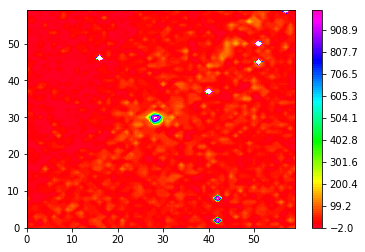

In [12]:
plt.contourf((mf)*1e6,cmap=plt.cm.gist_rainbow,\
             vmin=-2,vmax=1000,levels=np.linspace(-2,1000,100))#,np.linspace(830,850,101))
plt.colorbar()
print(np.min(mf*1e6),np.max(mf*1e6))

In [13]:
# nRD, xedges, yedge = np.histogram2d(decp,rap,bins=(dec_array,ra_array))
# plt.contourf(np.log10(nRD+1),levels=np.linspace(2.5,2.7,31),cmap=plt.cm.gist_rainbow)
# plt.colorbar()
# plt.show()
# # plt.hist(np.log10(nRD+1),bins=20)